# DLThon CV - Motorcycle Night Ride Semantic Segmentation

## Team 나봉규 (조준규, 이수봉, 최예나)

### 목표
- **Motocycle Night Ride 데이터셋 구성, 모델 훈련 및 결과물 시각화**
- **다양한 모델의 훈련 결과에 대한 성능 평가 비교**
- **Semantic Segmentation Task의 베이스라인 모델과 정량적, 정성적 분석**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Colab\ Notebooks/aiffel/MainProject3

/content/drive/MyDrive/Colab Notebooks/aiffel/MainProject3


In [3]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow import keras
from tensorflow.keras import layers, models, Input, Model, optimizers, utils, backend

In [4]:
tf.config.list_physical_devices('GPU')

[]

### (1) Motorcycle Night Ride 데이터셋 전처리

- Dataset Load, Augmentation을 위한 패키지 다운로드

In [ ]:
!pip install pycocotools
!pip install albumentations

- Augmentation

In [6]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(          # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(                   # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터는 224X224로 resize만 수행
                Resize(
                    width=224,
                    height=224
                    )
                ])

- Data Generator

In [7]:
from pycocotools.coco import COCO

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, coco_ann_file, image_dir, class_id_to_name, idx, batch_size=32, shuffle=True, augmentation=True):
        self.coco = COCO(coco_ann_file)
        self.image_dir = image_dir
        self.class_id_to_name = class_id_to_name
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_ids = list(idx)
        self.indexes = np.arange(len(self.image_ids))
        self.augmentation = augmentation
        if self.shuffle:
            random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = []             # batch_size 만큼의 X
        batch_masks = []            # batch_size 만큼의 Y

        for idx in batch_indexes:
            image_info = self.coco.loadImgs(self.image_ids[idx])[0]
            image_path = os.path.join(self.image_dir, image_info['file_name'])  # 이미지 파일 경로
            image = cv2.imread(image_path)                                      # 이미지 불러오기
            image_height, image_width, _ = image.shape                          # 이미지 shape

            # 이미지 annotation 정보
            annotation_ids = self.coco.getAnnIds(imgIds=image_info['id'])
            annotations_info = self.coco.loadAnns(annotation_ids)

            multi_class_mask = np.zeros((image_height, image_width, len(self.class_id_to_name)), dtype=np.uint8)

            # 각 어노테이션 정보를 이용하여 멀티클래스 객체 마스크를 생성
            for annotation_info in annotations_info:
                if 'segmentation' in annotation_info and 'category_id' in annotation_info:
                    segmentation = annotation_info['segmentation']
                    segmentation = [int(x) for x in segmentation[0]]            # 세그멘테이션 좌표
                    class_id = annotation_info['category_id']

                    # 클래스 ID를 이용하여 채널 인덱스 결정
                    channel_index = list(self.class_id_to_name.keys()).index(class_id)

                    # 세그멘테이션 좌표를 이미지 경계에 맞게 자르기
                    segmentation = [min(max(coord, 0), image_height - 1) for coord in segmentation[::2]]
                    segmentation = [min(max(coord, 0), image_width - 1) for coord in segmentation[1::2]]

                    # 마스크 생성 및 클래스 색상 설정
                    mask = self.coco.annToMask(annotation_info) * 255

                    # 마스크 영역을 클래스 색상으로 채우고 마스크를 멀티클래스 마스크에 추가
                    multi_class_mask[mask > 0, channel_index] = 255

                data = {
                "image": np.array(image),
                "mask" : np.array(multi_class_mask)
            }

            # Augmentation
            augmented = self.augmentation(**data)

            # Normalization
            image = augmented["image"]/255
            multi_class_mask = augmented["mask"]/255

            batch_data.append(image)
            batch_masks.append(multi_class_mask)

        return np.array(batch_data), np.array(batch_masks)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.indexes)

- train test split

In [8]:
import numpy as np

# 랜덤 시드 설정
np.random.seed(1004)

# 데이터 인덱스 생성
image_idx = list(range(1,201)) # 데이터의 인덱스 리스트

# 데이터를 train과 test로 나누기
test_ratio = 0.2  # 테스트 세트의 비율 (예: 20%)
num_test = int(len(image_idx) * test_ratio)  # 테스트 세트의 크기
test_idx = np.random.choice(image_idx, size=num_test, replace=False)  # 테스트 세트의 인덱스 선택

# 나머지 인덱스는 훈련 세트로 사용
train_idx = np.setdiff1d(image_idx, test_idx)

# int type list로 변환
train_idx = train_idx.astype('int32').tolist()
test_idx = test_idx.astype('int32').tolist()

- Train, Test data 생성

In [9]:
coco_ann_file = './motorcycle_night_ride/data/COCO_motorcycle.json'  # COCO 어노테이션 파일 경로
image_dir = './motorcycle_night_ride/data/images/'  # 이미지 디렉토리 경로
class_id_to_name = {  # 클래스 정보 정의
    1329681: 'Rider',
    1323885: 'My bike',
    1323884: 'Moveable',
    1323882: 'Lane Mark',
    1323881: 'Road',
    1323880: 'Undrivable',
}

batch_size = 5  # 배치 크기
shuffle = False  # 데이터 순서를 섞을지 여부

In [10]:
# COCO 객체 생성
coco = COCO(coco_ann_file)

# 이미지, 어노테이션, 클래스 정보 추출
images = coco.dataset['images']
annotations = coco.dataset['annotations']
categories = coco.dataset['categories']

loading annotations into memory...
Done (t=15.82s)
creating index...
index created!


In [11]:
# augmentation 객체 생성
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

In [12]:
# train, test data generator 생성
train_data_generator = CustomDataGenerator(coco_ann_file, image_dir, class_id_to_name, train_idx ,batch_size, shuffle, augmentation)
test_data_generator = CustomDataGenerator(coco_ann_file, image_dir, class_id_to_name, test_idx ,batch_size, shuffle, test_preproc)

loading annotations into memory...
Done (t=6.85s)
creating index...
index created!
loading annotations into memory...
Done (t=3.79s)
creating index...
index created!


- 배치 데이터 확인

(5, 224, 224, 3) (5, 224, 224, 6)


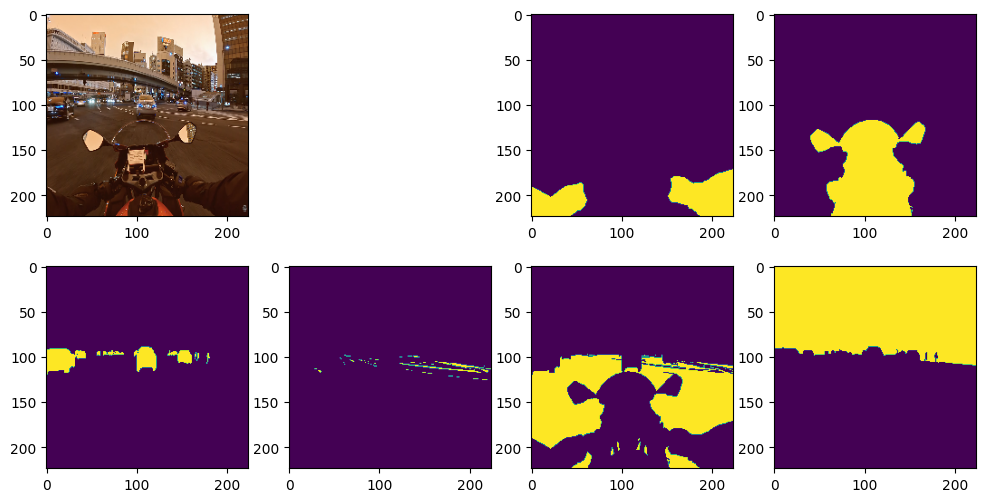

In [13]:
for epoch in range(1):
    for batch_data, batch_masks in test_data_generator:
        print(batch_data.shape, batch_masks.shape)
        plt.figure(figsize=(12, 6))

        plt.subplot(2, 4, 1)
        plt.imshow(batch_data[0])

        for i in range(6):
            plt.subplot(2, 4, i+3)
            plt.imshow(batch_masks[0, :, :, i])

        plt.show()
        break

### (2) Baseline 모델 구현

segmentation task 이기에 가장 기본이 되는 U-Net을 Baseline model로 선정하였다.

In [14]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [15]:
def UNET(n_classes=6,input_shape=(224,224,3)):
    inp = Input(input_shape)

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(n_classes, 1, activation = 'sigmoid', padding='same')(conv9)

    model = Model(inputs = inp, outputs=[conv10], name='U-Net')

    return model

- U-Net Summary

In [16]:
model_unet = UNET(input_shape=(224,224,3))
model_unet.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

### (3) U-Net++ 모델 구현

성능 향상을 위해 skip connection이 여럿 추가된 U-Net++를 비교 모델로 선택하였다.

In [17]:
def conv_block(inputs, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [18]:
def down_block(inputs, n_filters):
    x = conv_block(inputs, n_filters)
    x = conv_block(x, n_filters)
    d = layers.MaxPooling2D((2, 2))(x)

    return x, d

In [19]:
def up_block(inputs, skip_list, n_filters):
    u = layers.Conv2DTranspose(n_filters, (2, 2), strides=2, padding='same')(inputs)
    x = layers.Concatenate()(skip_list + [u])
    x = conv_block(x, n_filters)
    x = conv_block(x, n_filters)

    return x

In [20]:
def UNETPP(n_classes=6, input_shape=(224, 224, 3), deep_supervision=False):
    inputs = Input(shape=input_shape)
    output_size = [64, 128, 256, 512, 1024]

    x00, d = down_block(inputs, output_size[0])

    x10, d = down_block(d, output_size[1])
    x01 = up_block(x10, [x00], output_size[0])

    x20, d = down_block(d, output_size[2])
    x11 = up_block(x20, [x10], output_size[0])
    x02 = up_block(x11, [x00, x01], output_size[0])

    x30, d = down_block(d, output_size[3])
    x21 = up_block(x30, [x20], output_size[0])
    x12 = up_block(x21, [x10, x11], output_size[0])
    x03 = up_block(x12, [x00, x01, x02], output_size[0])

    x40, _ = down_block(d, output_size[4])
    x31 = up_block(x40, [x30], output_size[3])
    x22 = up_block(x31, [x20, x21], output_size[2])
    x13 = up_block(x22, [x10, x11, x12], output_size[1])
    x04 = up_block(x13, [x00, x01, x02, x03], output_size[0])

    x1 = layers.Conv2D(n_classes, 1, padding='same', activation='sigmoid')(x01)
    x2 = layers.Conv2D(n_classes, 1, padding='same', activation='sigmoid')(x02)
    x3 = layers.Conv2D(n_classes, 1, padding='same', activation='sigmoid')(x03)
    x4 = layers.Conv2D(n_classes, 1, padding='same', activation='sigmoid')(x04)

    if deep_supervision:
        x = [x1, x2, x3, x4]
    else:
        x = [x4]

    return Model(inputs, x, name='U-NetPP-D') if deep_supervision else Model(inputs, x, name='U-NetPP')

- U-Net++ Summary

In [21]:
model_unetpp = UNETPP(input_shape=(224,224,3))
model_unetpp.summary()

Model: "U-NetPP"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d_23[0][0]']              
 alization)                     )                                                           

### (4) 모델 학습

모델 성능 비교를 위해 총 4가지 모델을 생성하였다.
1. U-Net epoch 100 w augment
2. U-Net epoch 150 w augment
3. U-Net++ epoch 150 w augment
4. U-Net epoch 150 w.o augment

아래의 코드는 모델 학습 과정을 나타내는 코드일 뿐이고 실제 학습은 각각 진행되었다.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)

In [ ]:
from tensorflow.keras.optimizers import Adam

model_unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics=['accuracy'])

hist_unet = model_unet.fit(
    train_data_generator,
    validation_data=test_data_generator,
    steps_per_epoch=len(train_data_generator),
    callbacks=[checkpoint_callback],
    epochs=100
)

- 학습 결과 시각화(Ex. U-Net epoch 100)

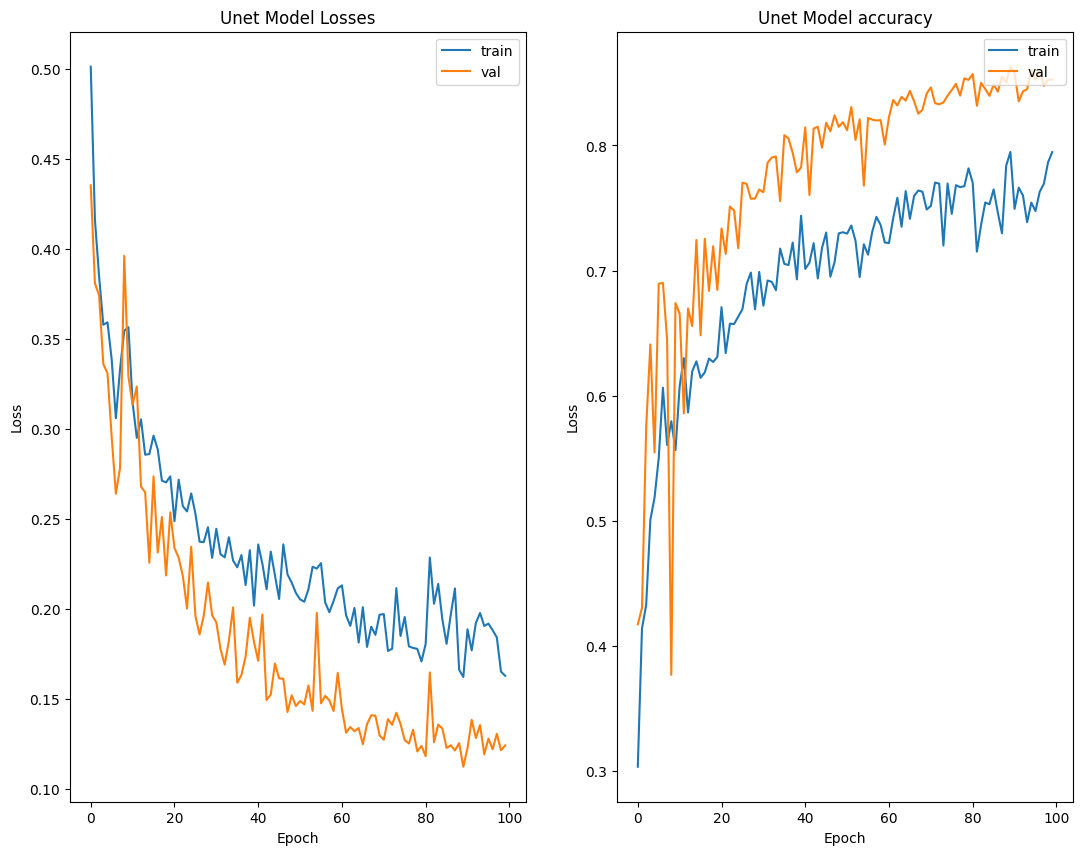

In [ ]:
plt.figure(figsize=(20, 10))

# train, validation loss graph
plt.subplot(1, 2, 1)
plt.plot(hist_unet.history['loss'])
plt.plot(hist_unet.history['val_loss'])
plt.title('Unet Model Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(hist_unet.history['accuracy'])
plt.plot(hist_unet.history['val_accuracy'])
plt.title('Unet Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

- 모델 저장(Ex. U-Net epoch 100)

In [ ]:
model_unet.save('./models/unet_epoch_100.h5')

- history 저장(Ex. U-Net epoch 100)

In [ ]:
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(hist_unet.history)

# save to json:
hist_json_file = 'sigmoid_history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

### (5) Prediction 결과 비교

학습된 4개의 모델을 먼저 불러온다.

In [22]:
MODEL_PATH = './models/'
model_file_list = ['unet_epochs_100.h5', 'unet_epochs_150.h5', 'unetpp_epochs_150.h5', 'unet_noaug_epochs_150.h5']

In [23]:
model_unet_100 = models.load_model(MODEL_PATH + model_file_list[0])
model_unet_150 = models.load_model(MODEL_PATH + model_file_list[1])
model_unetpp_150 = models.load_model(MODEL_PATH + model_file_list[2])
model_unet_noaug_150 = models.load_model(MODEL_PATH + model_file_list[3])

In [24]:
model_dict = {
    'U-Net epoch 100 w aug' : model_unet_100,
    'U-Net epoch 150 w aug' : model_unet_150,
    'U-Net++ epoch 150 w aug' : model_unetpp_150,
    'U-Net epoch 150 w.o aug' : model_unet_noaug_150,
}

- Segmentation 시각화를 위한 colormap 설정

In [25]:
colormap = [
    [65, 117, 6],
    [74, 114, 226],
    [57, 234, 92],
    [248, 231, 28],
    [155, 155, 155],
    [254, 166, 35]
]

- 모델 prediction 결과 시각화

In [26]:
def get_output(models, origin_img, label_img, colormap=colormap, preproc=test_preproc):
    fig_len = len(models) + 2
    plt.figure(figsize=(3 * fig_len, 3))

    plt.subplot(1, fig_len, 1)
    plt.title('Origin Image')
    plt.axis('off')
    plt.imshow(origin_img)                          # Origin Image

    for idx, (name, m) in enumerate(models.items()):
        pred = m(np.expand_dims(origin_img,axis=0))
        segment = np.argmax(pred, axis=3)           # 픽셀별로 가장 높은 class로 설정

        output = np.zeros((segment.shape[1], segment.shape[2], 3))

        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                output[i][j] = colormap[segment[0][i][j]]  # color 입히기

        output = tf.cast(output, tf.uint8)

        plt.subplot(1, fig_len, idx + 2)
        plt.title(f'{name}')
        plt.axis('off')
        plt.imshow(output)                          # Model Prediction Image

    origin_label = np.zeros((label_img.shape[0], label_img.shape[1], 3))

    for idx, label in enumerate(np.transpose(label_img, (2, 0, 1))):
        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                if label[i][j] == 1.:
                    origin_label[i][j] = colormap[idx]

    origin_label = tf.cast(origin_label, tf.uint8)

    plt.subplot(1, fig_len, fig_len)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.imshow(origin_label)                        # Ground Truth Mask

    plt.show()

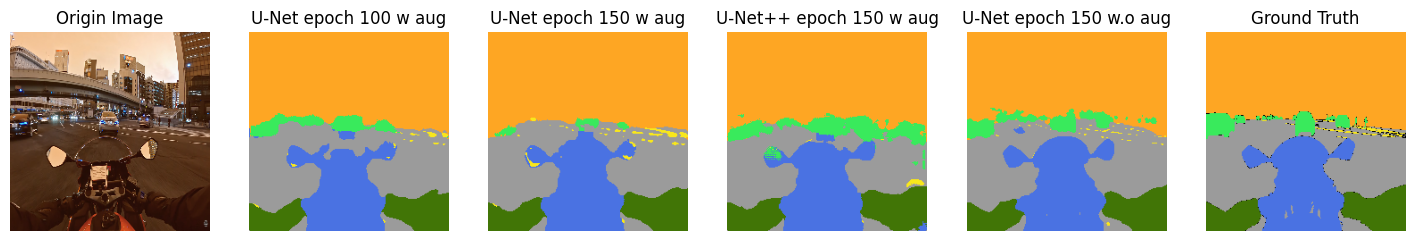

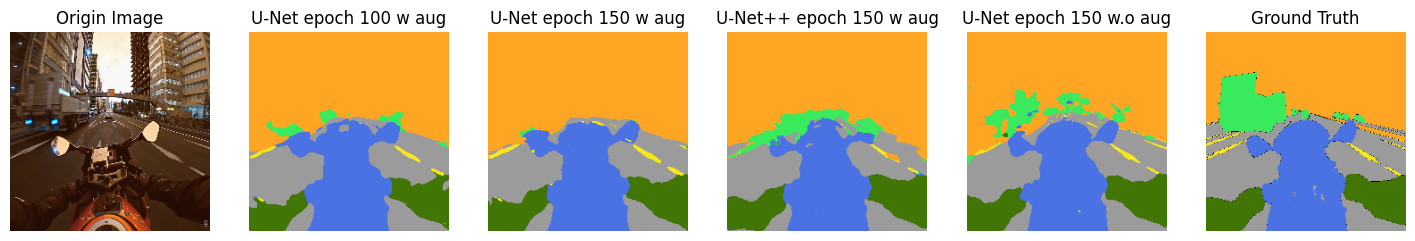

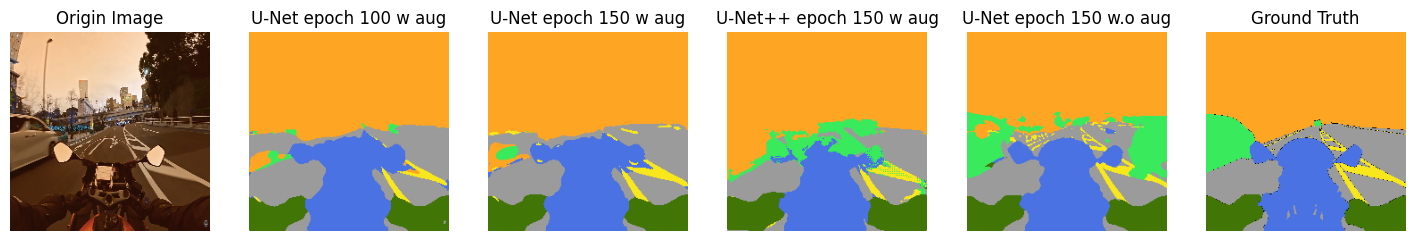

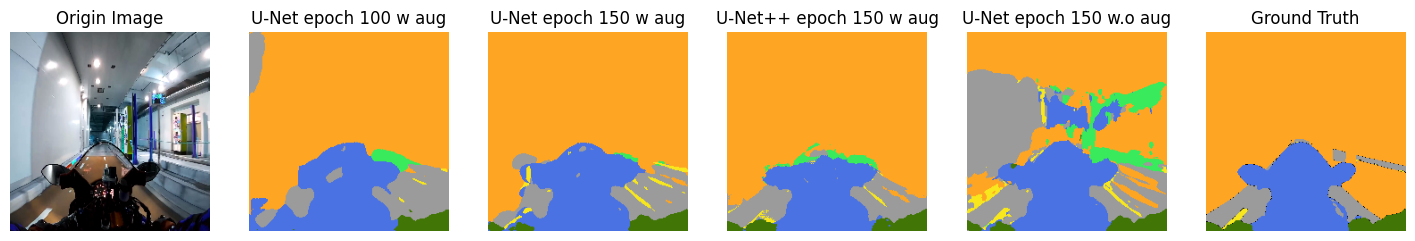

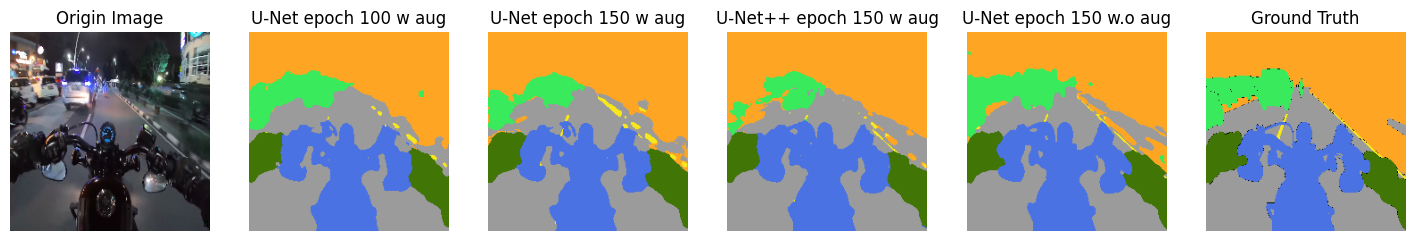

In [27]:
for epoch in range(1):
    for batch_data, batch_masks in test_data_generator:
        for i in range(batch_size):
            get_output(model_dict, batch_data[i], batch_masks[i])

        break

### (6) IoU 성능 비교

- Intersection over Union

In [30]:
def calculate_iou_score(targets, predictions, classes=class_id_to_name):
    iou_scores = []
    intersections = []
    unions = []

    for i, (_, name) in enumerate(classes.items()):
        intersection = np.logical_and(targets[i], predictions[i])       # 교집합 계산
        union = np.logical_or(targets[i], predictions[i])               # 합집합 계산
        iou_score = float(np.sum(intersection)) / float(np.sum(union))  # IoU 계산

        intersections.append(intersection)
        unions.append(union)
        iou_scores.append(iou_score)

        print(f'IoU of {name} : {iou_score:.4f}', end='    ')

    print(f'\nMean IoU : {np.mean(iou_scores):.4f}', end='    ')
    print(f'Pixel Accuracy : {np.sum(intersections) / np.sum(unions):.4f}\n')  # 최종 IoU

In [31]:
for epoch in range(1):
    for batch_data, batch_masks in test_data_generator:
        for idx in range(batch_size):
            print(f'Index {idx} of Batch')
            for n, m in model_dict.items():
                print(f'{n} IoUs')

                predictions = np.array(m(np.expand_dims(batch_data[idx], axis=0))[0])

                # 각 픽셀의 값을 1 또는 0으로 thresholding
                for i in range(predictions.shape[0]):
                    for j in range(predictions.shape[1]):
                        for k in range(predictions.shape[2]):
                            if predictions[i][j][k] >= 0.5:
                                predictions[i][j][k] = 1
                            else:
                                predictions[i][j][k] = 0

                calculate_iou_score(np.transpose(batch_masks[idx], (2, 0, 1)), np.transpose(predictions, (2, 0, 1)))

            print()

        break

Index 0 of Batch
U-Net epoch 100 w aug IoUs
IoU of Rider : 0.8907    IoU of My bike : 0.8654    IoU of Moveable : 0.4382    IoU of Lane Mark : 0.0633    IoU of Road : 0.7994    IoU of Undrivable : 0.9617    
Mean IoU : 0.6698    Pixel Accuracy : 0.8665

U-Net epoch 150 w aug IoUs
IoU of Rider : 0.9425    IoU of My bike : 0.9175    IoU of Moveable : 0.1107    IoU of Lane Mark : 0.2183    IoU of Road : 0.8877    IoU of Undrivable : 0.9472    
Mean IoU : 0.6706    Pixel Accuracy : 0.8891

U-Net++ epoch 150 w aug IoUs
IoU of Rider : 0.8866    IoU of My bike : 0.8802    IoU of Moveable : 0.3265    IoU of Lane Mark : 0.0000    IoU of Road : 0.6797    IoU of Undrivable : 0.9538    
Mean IoU : 0.6211    Pixel Accuracy : 0.8248

U-Net epoch 150 w.o aug IoUs
IoU of Rider : 0.9619    IoU of My bike : 0.9599    IoU of Moveable : 0.5083    IoU of Lane Mark : 0.2807    IoU of Road : 0.9057    IoU of Undrivable : 0.9560    
Mean IoU : 0.7621    Pixel Accuracy : 0.9155


Index 1 of Batch
U-Net epoch 1